In [1]:
import os
import nltk
import random 
import sent2vec
import evaluate
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from nltk import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from string import punctuation

from scipy.spatial import distance
from scipy.stats import f_oneway, chisquare

from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.stats.libqsturng import psturng

In [2]:
df = pd.read_csv("llm_for_bcc_final.tsv", sep="\t")
print(df.head())

  Number                                           Question  \
0     Q1  What treatment options for basal cell carcinom...   
1     Q2  Which treatment option for basal cell carcinom...   
2     Q3  What medications are typically used as topical...   
3     Q4  Are there any risks associated with topical tr...   
4     Q5  Are there any drug interactions or contraindic...   

                                         ChatGPT 3.5  \
0  Basal cell carcinoma (BCC) treatment options v...   
1  The treatment option for basal cell carcinoma ...   
2  Topical medications are generally not the firs...   
3  Topical treatments for basal cell carcinoma (B...   
4  When using topical medications for basal cell ...   

                                              Gemini  \
0  Here's a breakdown of the various treatment op...   
1  The treatment option for basal cell carcinoma ...   
2  Here's a breakdown of topical treatments for b...   
3  Absolutely, there are risks associated with to...   
4  Y

## Distribution of Answer Lengths

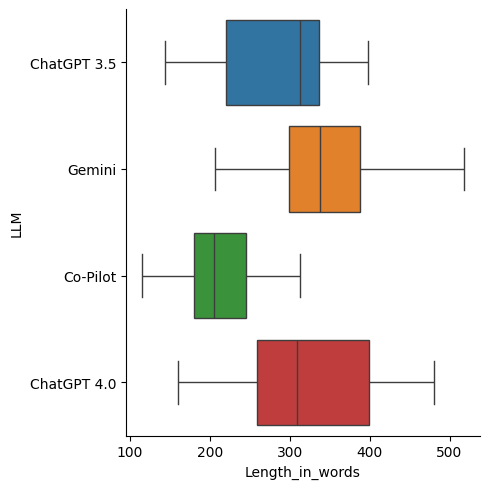

In [3]:
def plot_lengths(df):
    #https://seaborn.pydata.org/tutorial/distributions.html 
    gpt_lengths =  [len(x.split(" ")) for x in list(df["ChatGPT 3.5"])]
    gemini_lengths = [len(x.split(" ")) for x in list(df["Gemini"])]
    copilot_lengths = [len(x.split(" ")) for x in list(df["Co-Pilot"])]
    gpt4_lengths =  [len(x.split(" ")) for x in list(df["ChatGPT 4.0"])]

    lengths = gpt_lengths + gemini_lengths + copilot_lengths + gpt4_lengths
    models = ["ChatGPT 3.5" for x in gpt_lengths] + ["Gemini" for x in gemini_lengths] + ["Co-Pilot" for x in copilot_lengths] + ["ChatGPT 4.0" for x in gpt4_lengths]
    
    data = {"Length_in_words": lengths, "LLM": models}
    df2 = pd.DataFrame.from_dict(data)
    #sns.displot(df2, x="Length_in_words", hue="LLM", multiple="dodge")
    sns.catplot(data=df2, x="Length_in_words", y="LLM", kind="box", hue="LLM")

plot_lengths(df)

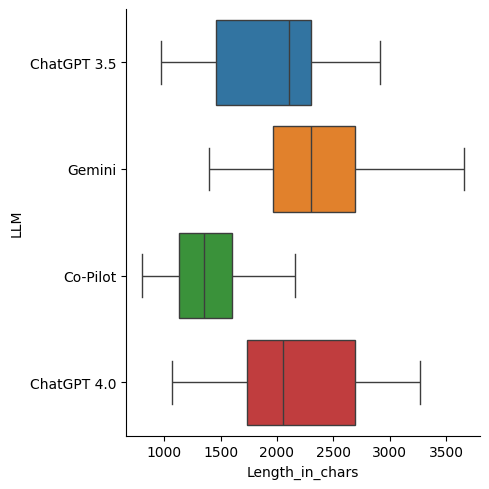

In [4]:
def plot_chars(df):
    #https://seaborn.pydata.org/tutorial/distributions.html 
    gpt_lengths =  [len(x) for x in list(df["ChatGPT 3.5"])]
    gemini_lengths = [len(x) for x in list(df["Gemini"])]
    copilot_lengths = [len(x) for x in list(df["Co-Pilot"])]
    gpt4_lengths =  [len(x) for x in list(df["ChatGPT 4.0"])]

    lengths = gpt_lengths + gemini_lengths + copilot_lengths + gpt4_lengths
    models = ["ChatGPT 3.5" for x in gpt_lengths] + ["Gemini" for x in gemini_lengths] + ["Co-Pilot" for x in copilot_lengths] + ["ChatGPT 4.0" for x in gpt4_lengths]
    
    data = {"Length_in_chars": lengths, "LLM": models}
    df2 = pd.DataFrame.from_dict(data)
    sns.catplot(data=df2, x="Length_in_chars", y="LLM", kind="box", hue="LLM")

plot_chars(df)

#### Take-Aways:

**Co-Pilot** gives the shortest responses, with a mean of ~200 words. 
ChatGPT **v3.5** and **v4.0** have similar, though not identical, distributions for answer length, although **v4.0** has a slightly wider distrubtion. 
**Gemini** has the longest average response lengths, also with the tail end of the distribution stretching further than the other language models.

# BLEU 

Taken from [Huggingface](https://huggingface.co/spaces/evaluate-metric/bleu) : 

```
BLEU (Bilingual Evaluation Understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine’s output and that of a human: “the closer a machine translation is to a professional human translation, the better it is” – this is the central idea behind BLEU. BLEU was one of the first metrics to claim a high correlation with human judgements of quality, and remains one of the most popular automated and inexpensive metrics.

Scores are calculated for individual translated segments—generally sentences—by comparing them with a set of good quality reference translations. Those scores are then averaged over the whole corpus to reach an estimate of the translation’s overall quality. Neither intelligibility nor grammatical correctness are not taken into account.

BLEU and BLEU-derived metrics are most often used for machine translation.

BLEU’s output is always a number between 0 and 1. This value indicates how similar the candidate text is to the reference texts, with values closer to 1 representing more similar texts. Few human translations will attain a score of 1, since this would indicate that the candidate is identical to one of the reference translations. For this reason, it is not necessary to attain a score of 1. Because there are more opportunities to match, adding additional reference translations will increase the BLEU score.
```

In [49]:
bleu_dict = {"index": [], "bleu": [], "pair": []} #cosine similarity dict
bleu = evaluate.load("bleu")

weights = (0.25, 0.25, 0, 0)  # Weights for uni-gram, bi-gram, tri-gram, and 4-gra 
def bleu_similarity(x, y):
    column_x = list(df[x])
    column_y = list(df[y])
    assert len(column_x) == len(column_y)
    i = 1
    for t1, t2 in zip(column_x, column_y):
        # score = nltk.translate.bleu_score.sentence_bleu(t1.lower().split(" "), t2.lower().split(" "), weights=weights)
        # print(score)
        score = bleu.compute(predictions=[t1], references=[t2])["bleu"]
        bleu_dict["bleu"].append(score)
        bleu_dict["pair"].append(f"{x} & {y}")
        bleu_dict["index"].append(i)
        i += 1
        
####### GPT3 vs the rest (3)
print("ChatGPT 3.5 and Gemini")
bleu_similarity("ChatGPT 3.5", "Gemini")
print("--------------------------------------------------------")
print("ChatGPT 3.5 and Co-Pilot")
bleu_similarity("ChatGPT 3.5", "Co-Pilot")
print("--------------------------------------------------------")
print("ChatGPT 3.5 and ChatGPT 4.0")
bleu_similarity("ChatGPT 3.5", "ChatGPT 4.0")
print("--------------------------------------------------------")

######## Gemini vs (the rest - GPT3) = 2
print("Gemini and Co-Pilot")
bleu_similarity("Gemini", "Co-Pilot")
print("--------------------------------------------------------")
print("Gemini and ChatGPT 4.0")
bleu_similarity("Gemini", "ChatGPT 4.0")
print("--------------------------------------------------------")

####### Co-Pilot vs (the rest - GPT3 - Gemini ) = 1
print("Co-Pilot and GPT 4.0")
bleu_similarity("Co-Pilot", "ChatGPT 4.0")
print("--------------------------------------------------------")

####### GPT4 vs (the rest - GPT3 - Gemini - CoPilot) = 0    

ChatGPT 3.5 and Gemini
--------------------------------------------------------
ChatGPT 3.5 and Co-Pilot
--------------------------------------------------------
ChatGPT 3.5 and ChatGPT 4.0
--------------------------------------------------------
Gemini and Co-Pilot
--------------------------------------------------------
Gemini and ChatGPT 4.0
--------------------------------------------------------
Co-Pilot and GPT 4.0
--------------------------------------------------------


<Axes: xlabel='index', ylabel='bleu'>

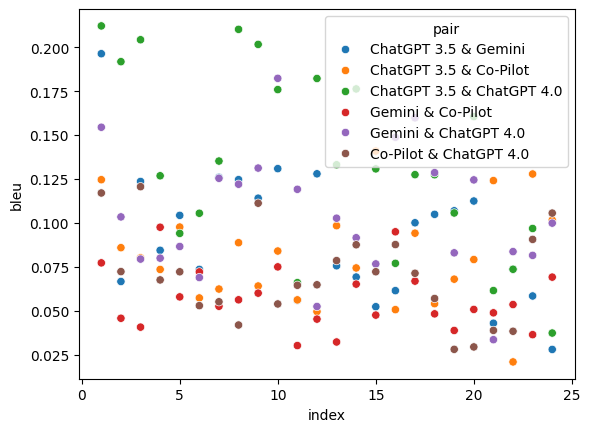

In [6]:
sns.scatterplot(data=bleu_dict, x="index", y="bleu", hue="pair") # sanity check 

<Axes: xlabel='bleu', ylabel='pair'>

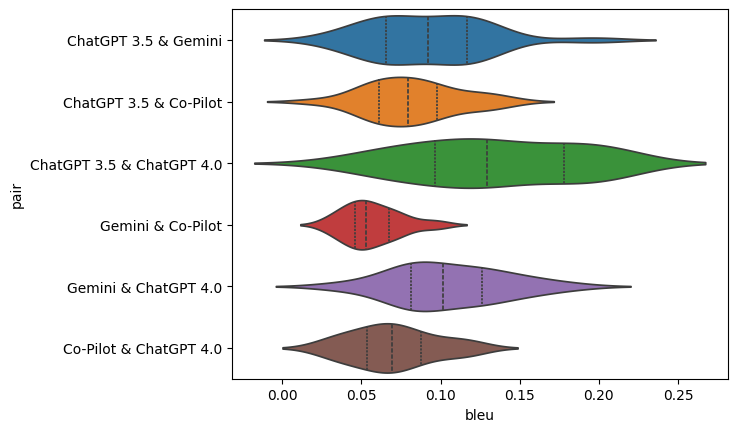

In [7]:
sns.violinplot(data=bleu_dict, x="bleu", y="pair", hue="pair", inner="quart")

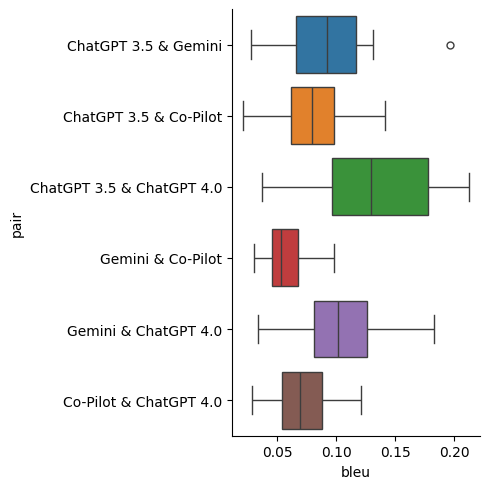

In [8]:
sns.catplot(data=bleu_dict, x="bleu", y="pair", kind="box", hue="pair")

<Axes: xlabel='bleu', ylabel='Count'>

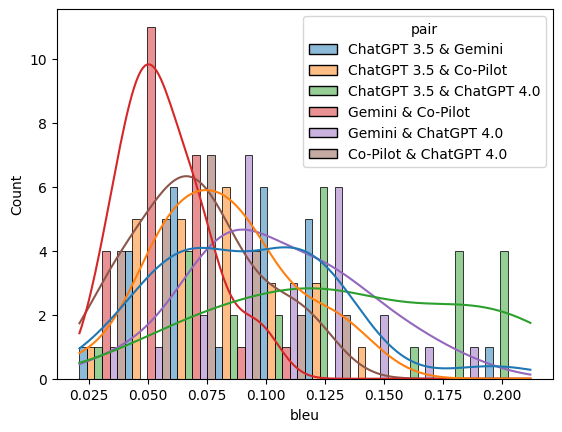

In [9]:
sns.histplot(data=bleu_dict, x="bleu", bins=10, hue="pair", multiple="dodge", kde=True)

<Axes: xlabel='bleu', ylabel='Density'>

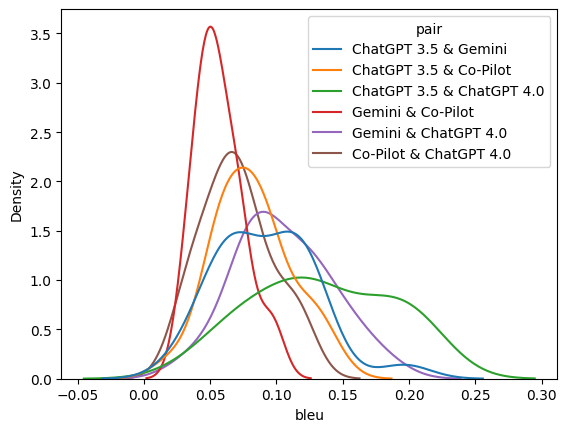

In [10]:
sns.kdeplot(data=bleu_dict, x="bleu", hue="pair")

<Axes: xlabel='bleu', ylabel='Proportion'>

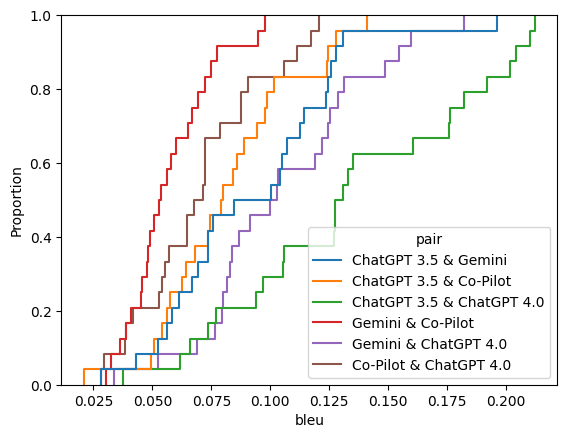

In [11]:
sns.ecdfplot(data=bleu_dict, x="bleu", hue="pair")

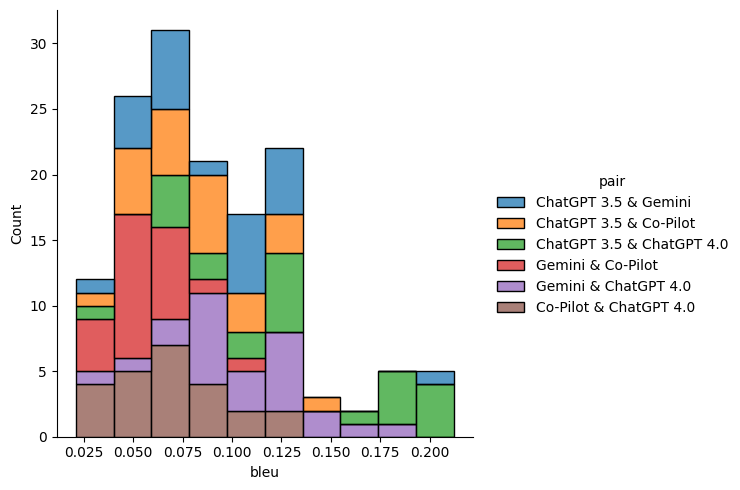

In [12]:
sns.displot(data=bleu_dict, x="bleu", bins=10, hue="pair", multiple="stack")

In [41]:
def stats_bleu(): 
    g3_ge = []
    g3_co = []
    g3_g4 = []
    ge_co = []
    ge_g4 = []
    co_g4 = []
    
    for score, model in zip(bleu_dict['bleu'], bleu_dict['pair']):
        if model == 'ChatGPT 3.5 & Gemini':
            g3_ge.append(score)
        elif model == 'ChatGPT 3.5 & Co-Pilot':
            g3_co.append(score)
        elif model == 'ChatGPT 3.5 & ChatGPT 4.0':
            g3_g4.append(score)
        elif model == 'Gemini & Co-Pilot':
            ge_co.append(score)
        elif model == 'Gemini & ChatGPT 4.0':
            ge_g4.append(score)
        elif model == 'Co-Pilot & ChatGPT 4.0':
            co_g4.append(score)
        else:
            print("ERROR")
        
    assert len(g3_ge) == len(g3_co) == len(g3_g4) == len(ge_co) == len(ge_g4) == len(co_g4)
            
    print(f_oneway(g3_ge, g3_co, g3_g4, ge_co, ge_g4, co_g4))

stats_bleu()

F_onewayResult(statistic=14.895211265554487, pvalue=1.1162920040483667e-11)


In [42]:
res = pairwise_tukeyhsd(bleu_dict['bleu'], bleu_dict['pair'])
print(res)
print(f"p-values: {res.pvalues}")

                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
          group1                  group2         meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------
ChatGPT 3.5 & ChatGPT 4.0 ChatGPT 3.5 & Co-Pilot  -0.0523    0.0 -0.0812 -0.0234   True
ChatGPT 3.5 & ChatGPT 4.0   ChatGPT 3.5 & Gemini  -0.0416 0.0008 -0.0705 -0.0127   True
ChatGPT 3.5 & ChatGPT 4.0 Co-Pilot & ChatGPT 4.0  -0.0639    0.0 -0.0928  -0.035   True
ChatGPT 3.5 & ChatGPT 4.0   Gemini & ChatGPT 4.0  -0.0289 0.0503 -0.0578     0.0  False
ChatGPT 3.5 & ChatGPT 4.0      Gemini & Co-Pilot  -0.0771    0.0  -0.106 -0.0482   True
   ChatGPT 3.5 & Co-Pilot   ChatGPT 3.5 & Gemini   0.0107 0.8941 -0.0183  0.0396  False
   ChatGPT 3.5 & Co-Pilot Co-Pilot & ChatGPT 4.0  -0.0116 0.8542 -0.0405  0.0173  False
   ChatGPT 3.5 & Co-Pilot   Gemini & ChatGPT 4.0   0.0234 0.1866 -0.0055  0.0523  False
   ChatGPT 3.5 & Co-Pilot      G

### Take-aways

With BLEU scores, we see that ChatGPT 3.5 and ChatGPT 4.0 generated responses are the most similar, accross the combinations of models, meanwhile Gemini and Co-Pilot have the least n-gram overlap. 

For the statistical significance tests, I used the one-way ANOVA to test the null hypothesis that the pairs have the same population mean.
**The problem is that I do not believe we have independent variables** because pair1(chatgpt3.5 + gemini) will of course be more similar to pair2(chatgpt3.5 + copilot) than it would be to pair4(gemini + copilot). 

If we set asside this gross abuse of statistics for a moment, then the Tukey HSD test confirms meaningful differences between those marked `True` in the table above.  

# ClinicalBERT 

Here we examine the pair-wise similarity of **responses** generated by the language models, for a series of queries. We compare all models against all models, resulting in 6 unique comparisons (i.e., "ChatGPT 3.5 vs Gemini" is the same as "Gemini vs ChatGPT 3.5", so we do not run the analysis twice). 

The similarity of responses are quantitatively examined by leveraging an open-source language model, specifically trained over clinical data (i.e., `ClinicalBERT`, which is a DistilBERT model). Specifically, we encode the text through the model to obtain a distributed representation of the text, which is meaningful in vectorspace. Our approach is in accordance with the findings [Cai et al., 2021 (@ICLR)](https://openreview.net/pdf?id=xYGNO86OWDH), where we specifically use the 5th layer of the models output, for improved isotropy of the embeddings, ultimately leading to more meaningful results when we calculate the distance of two embeddings with **cosine similarity**. Concretely, two embeddings of the same text would have a cosine similarity (cos) of 1, while two embeddings of completely different texts (with no lexical, syntactic, or semantic overlap) would be close to 0. 

A **limitation** of this method is that `ClinicalBERT` cannot encode texts exceeding a certain length (512 characters). Thus exceedingly long generated answers are truncated. 

See:

[ClinicalBERT on Huggingface](https://huggingface.co/medicalai/ClinicalBERT)

[Wang et al., 2023 in Nature Medicine](https://www.nature.com/articles/s41591-023-02552-9)

In [13]:
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")                                                                        
bert_model = AutoModel.from_pretrained("medicalai/ClinicalBERT") 

In [14]:
bert_cs_dict = {"index": [], "cos": [], "pair": []} #cosine similarity dict

def bert_similarity(x, y):
    #https://huggingface.co/medicalai/ClinicalBERT
    
    column_x = list(df[x])
    column_y = list(df[y])
    assert len(column_x) == len(column_y)
    i = 1
    for t1, t2 in zip(column_x, column_y):
        encoded_t1 = tokenizer(t1[:511], return_tensors="pt").to("cpu")
        encoded_t2 = tokenizer(t2[:511], return_tensors="pt").to("cpu")

        #TODO padding 512
        output1 = bert_model(**encoded_t1)
        output2 = bert_model(**encoded_t2)
        v1 = output1[0].detach().numpy()[0]
        v2 = output2[0].detach().numpy()[0]
        cosine_sim = 1 - distance.cosine(v1[4], v2[4]) #rather look at 5th layer per https://openreview.net/pdf?id=xYGNO86OWDH
        print(f"Q{i}: {cosine_sim}")
        bert_cs_dict["cos"].append(cosine_sim)
        bert_cs_dict["pair"].append(f"{x} & {y}")
        bert_cs_dict["index"].append(i)
        i += 1
        
####### GPT3 vs the rest (3)
print("ChatGPT 3.5 and Gemini")
bert_similarity("ChatGPT 3.5", "Gemini")
print("--------------------------------------------------------")
print("ChatGPT 3.5 and Co-Pilot")
bert_similarity("ChatGPT 3.5", "Co-Pilot")
print("--------------------------------------------------------")
print("ChatGPT 3.5 and ChatGPT 4.0")
bert_similarity("ChatGPT 3.5", "ChatGPT 4.0")
print("--------------------------------------------------------")

######## Gemini vs (the rest - GPT3) = 2
print("Gemini and Co-Pilot")
bert_similarity("Gemini", "Co-Pilot")
print("--------------------------------------------------------")
print("Gemini and ChatGPT 4.0")
bert_similarity("Gemini", "ChatGPT 4.0")
print("--------------------------------------------------------")

####### Co-Pilot vs (the rest - GPT3 - Gemini ) = 1
print("Co-Pilot and GPT 4.0")
bert_similarity("Co-Pilot", "ChatGPT 4.0")
print("--------------------------------------------------------")

####### GPT4 vs (the rest - GPT3 - Gemini - CoPilot) = 0

ChatGPT 3.5 and Gemini
Q1: 0.34400102496147156
Q2: 0.9676914811134338
Q3: 0.31799614429473877
Q4: 0.38186395168304443
Q5: 0.39018261432647705
Q6: 0.26437267661094666
Q7: 0.51911461353302
Q8: 0.9966889023780823
Q9: 0.3180488049983978
Q10: 0.9796056151390076
Q11: 0.9632912278175354
Q12: 0.2410484254360199
Q13: 0.9814104437828064
Q14: 0.3427354097366333
Q15: 0.39528483152389526
Q16: 0.21689392626285553
Q17: 0.23512312769889832
Q18: 0.9862741231918335
Q19: 0.34833505749702454
Q20: 0.4866860508918762
Q21: 0.40888452529907227
Q22: 0.9626065492630005
Q23: 0.2641645669937134
Q24: 0.1740773767232895
--------------------------------------------------------
ChatGPT 3.5 and Co-Pilot
Q1: 0.9767695069313049
Q2: 0.41780367493629456
Q3: 0.735714852809906
Q4: 0.4001087546348572
Q5: 0.4523905813694
Q6: 0.5040133595466614
Q7: 0.19378449022769928
Q8: 0.9930664896965027
Q9: 0.3895154297351837
Q10: 0.9679776430130005
Q11: 0.952936053276062
Q12: 0.2619725167751312
Q13: 0.9768242835998535
Q14: 0.3524553179740

<Axes: xlabel='index', ylabel='cos'>

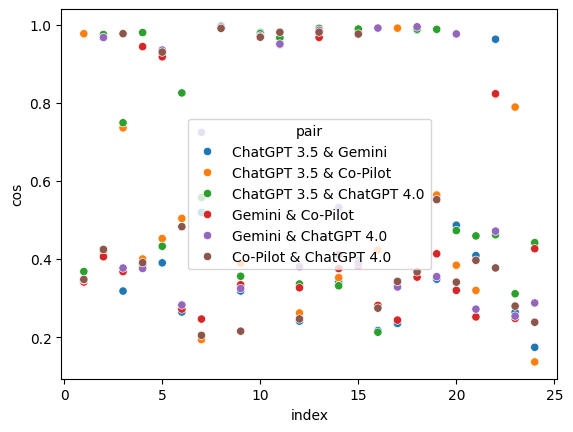

In [15]:
sns.scatterplot(data=bert_cs_dict, x="index", y="cos", hue="pair") # sanity check 

<Axes: xlabel='cos', ylabel='pair'>

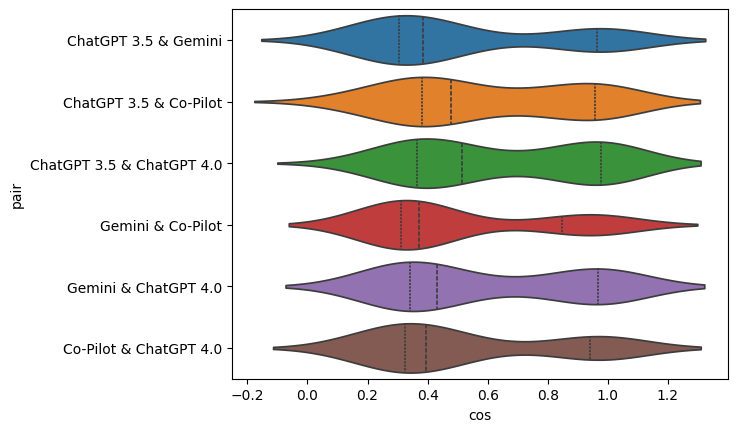

In [16]:
sns.violinplot(data=bert_cs_dict, x="cos", y="pair", hue="pair", inner="quart")

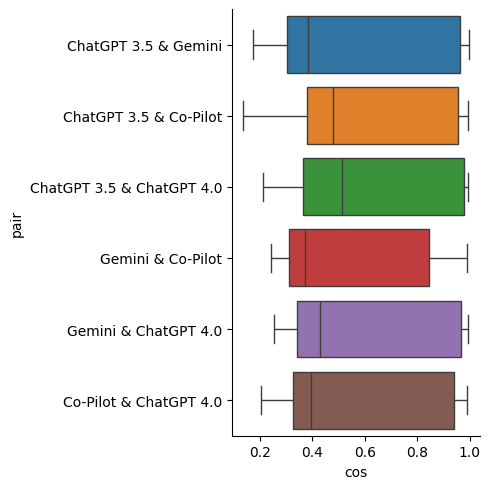

In [17]:
sns.catplot(data=bert_cs_dict, x="cos", y="pair", kind="box", hue="pair")

<Axes: xlabel='cos', ylabel='Count'>

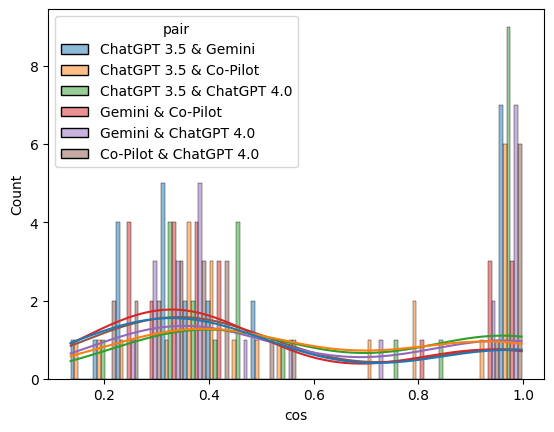

In [18]:
sns.histplot(data=bert_cs_dict, x="cos", bins=20, hue="pair", multiple="dodge", kde=True)

<Axes: xlabel='cos', ylabel='Density'>

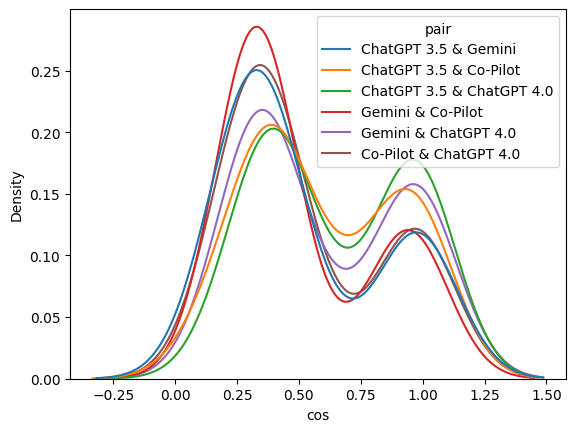

In [19]:
sns.kdeplot(data=bert_cs_dict, x="cos", hue="pair")

<Axes: xlabel='cos', ylabel='Proportion'>

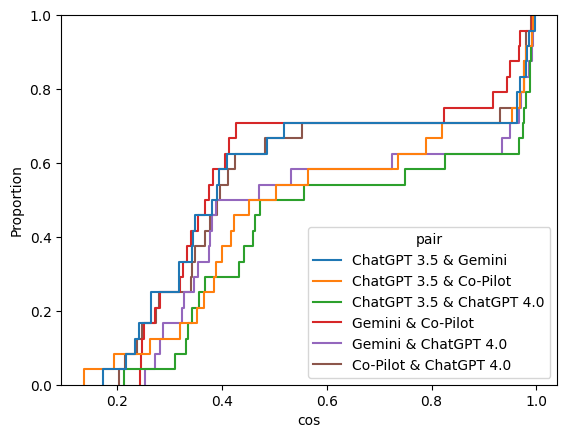

In [20]:
sns.ecdfplot(data=bert_cs_dict, x="cos", hue="pair")

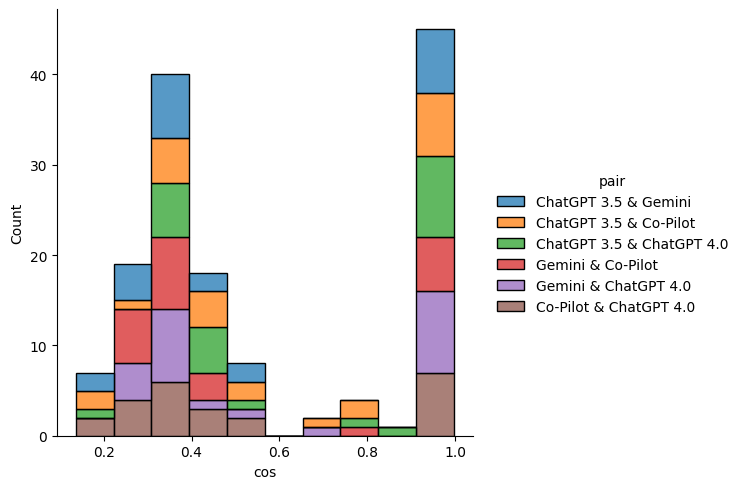

In [21]:
sns.displot(data=bert_cs_dict, x="cos", bins=10, hue="pair", multiple="stack")

#### Take-Aways

Generally, the language models have similar distributions of cosine similarities over embedded responses. The median similarity of answers is reasonably low (~40% similar; see violinplot and catplot) -- this could be interpreted that there is still meaningful overlap, but the content is somewhat different. Still, every combination of models shows that the pair-wise similarity can vary broadly across questions; indeed, in all visualizations, we see that the range of **observed** cosine similarity values falls between 0, 1. Interestingly, all pair-wise model comparisons show a dip between the 50-60% similarity gap. 

In [44]:
def stats_bert():
    g3_ge = []
    g3_co = []
    g3_g4 = []
    ge_co = []
    ge_g4 = []
    co_g4 = []
    
    for score, model in zip(bert_cs_dict['cos'], bert_cs_dict['pair']):
        if model == 'ChatGPT 3.5 & Gemini':
            g3_ge.append(score)
        elif model == 'ChatGPT 3.5 & Co-Pilot':
            g3_co.append(score)
        elif model == 'ChatGPT 3.5 & ChatGPT 4.0':
            g3_g4.append(score)
        elif model == 'Gemini & Co-Pilot':
            ge_co.append(score)
        elif model == 'Gemini & ChatGPT 4.0':
            ge_g4.append(score)
        elif model == 'Co-Pilot & ChatGPT 4.0':
            co_g4.append(score)
        else:
            print("ERROR")
        
    assert len(g3_ge) == len(g3_co) == len(g3_g4) == len(ge_co) == len(ge_g4) == len(co_g4)
            
    print(f_oneway(g3_ge, g3_co, g3_g4, ge_co, ge_g4, co_g4))

stats_bert()

F_onewayResult(statistic=0.8435873288449524, pvalue=0.5210483710771985)


### Example of Interpreting of Cosine Similarity:

#### Q1 cos(ChatGPT 3.5, Gemini) = 0.34 (a little, but not very similar)

**ChatGPT 3.5:** (first 512 chars)

**"Basal cell carcinoma (BCC)** treatment options vary depending on factors such as the size, location, and subtype of the **tumor**, as well as the patient's overall health and preferences. Here are some common treatment options: Surgical excision: This involves **cutting out the tumor along with a margin of healthy tissue.** It's often effective for most BCCs, especially those on the trunk, limbs, and areas where the skin can be easily pulled together after removal. Mohs micrographic surgery: This is a specialized su"

```
Heather's notes:
This answer seems to give brief descriptions of treatment options, and when one would use them. 

```

**Gemini** (first 512 chars)

"Here's a breakdown of the various treatment options for **basal cell carcinoma (BCC)**, the most common form of skin **cancer**: Surgical Treatments Mohs micrographic surgery: This highly specialized surgery has the highest cure rate for BCCs. The **surgeon removes the visible tumor and thin layers of surrounding skin**, which are examined under a microscope immediately. This process continues until no more cancer cells are detected. Mohs surgery is ideal for BCCs in sensitive areas (like the face), recurrent BCCs, or"

```
Heather's notes:
I don't think its that dissimilar than the ChatGPT 3.5 one, but it has quite a bit of extra information, which ChatGPT 3.5 did not, and the response seems to be oriented towards the patient, with phrases like ("the best treatment for you"). Thus the "intended audience" of the generated text seems to be different across the generations. 
```



#### Q2 cos (ChatGPT 3.5, Gemini) = 0.96 (highly similar)

(I've **bolded** examples of similarity between the two)

**ChatGPT 3.5** 


**"The treatment option for basal cell carcinoma (BCC) with the highest clearance rate** typically depends on various factors including the size, location, and subtype of the tumor, as well as the patient's overall health and preferences. However, **Mohs micrographic surgery** is often considered to have one of the **highest clearance rates for BCC.**
Mohs surgery **involves removing thin layers of cancerous tissue and examining them under a microscope immediately after removal. This process allows the surgeon to precisely target and remove cancerous cells while sparing healthy tissue.** The procedure continues layer by layer until no cancer cells are detected, resulting in a very high cure rate and **minimal damage** to surrounding healthy tissue.
**Other treatment options** for BCC include **standard excision surgery**, cryotherapy (freezing), **curettage and electrodesiccation** (scraping and **burning**), **radiation therapy**, and **topical medications such as imiquimod or 5-fluorouracil (5-FU)**. The **choice of treatment depends on various factors**, and it's best determined in consultation with a dermatologist or oncologist specializing in skin cancer treatment."


**Gemini**


**"The treatment option for basal cell carcinoma (BCC) with the highest clearance rate** is Mohs micrographic surgery. Here's some more information about it and other common treatment options:
**Mohs Micrographic Surgery**
Highest clearance rate: Mohs surgery has the **highest cure rates for BCC**, especially for high-risk tumors, recurrent tumors, or those in critical cosmetic areas (like the face). Success rates are around 99% for new BCCs and around 95% for recurrent cancers.
How it works: **The surgeon removes the visible tumor and a thin layer of surrounding tissue. This tissue is immediately examined under a microscope. If cancer cells are still present, another layer is removed. This continues until no cancer cells remain.**
Advantages: **Maximizes healthy tissue preservation** while ensuring the complete removal of the cancer.
Disadvantages:It's more time-consuming and complex than other procedures; therefore, it tends to be more expensive.
**Other Treatment Options**
**Surgical Excision**: The tumor and a margin of healthy skin are removed. It's a good option for smaller, low-risk BCCs. Cure rates are generally above 95%.
**Electrodessication and Curettage** (ED&C): The tumor is scraped away with a curette and the base is cauterized **(burned)** with an electric needle. This is often used for low-risk, superficial BCCs. It has lower cure rates than surgery.
**Radiation Therapy**: Uses high-energy rays to kill cancer cells. This is a good option for older patients, tumors in difficult-to-treat areas, or when surgery isn't possible. Cure rates are generally good.
**Topical medications: Creams like imiquimod or 5-fluorouracil** can treat superficial BCCs. Cure rates are lower than surgery but they are non-invasive.
Important Considerations:
**The best treatment choice depends on several factors**, including:
BCC type and size: Superficial BCCs may be suitable for topical medication, while larger, more invasive BCCs frequently necessitate surgery.
Location: BCCs in sensitive areas like the face often benefit from Mohs surgery for the best cosmetic outcome.
Patient health and preferences: Other medical conditions or personal preference can influence treatment choice.
Always consult a dermatologist to discuss the best treatment option for your specific case."


# Sent2Vec

Although `ClinicalBERT` is a state-of-the-art model, transformer-based architectures are known to suffer from ansiotropy (which leads to high cosine similarities) (see [Cai et al., 2021 (@ICLR)](https://openreview.net/pdf?id=xYGNO86OWDH)). Additionally, models like `ClinicalBERT` are intended to encode sentences and short paragraphs, rather than long documents. In some cases, the answers generated by the language models were too long to be embeded by `ClinicalBERT` in its entirely. 

For these reasons (ansiotropy and document length constraints), we also use `BioSent2Vec` (see [here](https://github.com/ncbi-nlp/BioSentVec/tree/master)), an older text embedding model, which doesn't suffer from the same ansiotrophy as transformer-based models, and additionally can encode the entire document. `BioSent2Vec` was trained on roughly 5B words from PubMed and the MIMIC dataset. This means that the domain of `BioSent2Vec` consists predominately of **medical research** rather than clinical notes, though some are present. 

A **limitation** of `BioSent2Vec` is that this method is very reliant on custom text cleaning heuristics. That is, similarity is artificially inflated by stop words (i.e., filler words like "a", "the", "he", which all documents will have, regardless of topic).

With `BioSent2Vec`, we can produce text embeddings of the answers generated by the language models, and measure them with cosine similarity, as above. 

In [50]:
model = sent2vec.Sent2vecModel()
model.load_model("/Users/AZ01DN/Downloads/BioSentVec_PubMed_MIMICIII-bigram_d700.bin")

In [51]:
stop_words = list(stopwords.words('english')) + ["patient", "doctor", "physician", "skin", "bcc", "basal", "cell", "carcinoma"]

def cleaner(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]
    #print(' '.join(tokens))
    return ' '.join(tokens) 

In [52]:
cs_dict = {"index": [], "cos": [], "pair": []} #cosine similarity dict

def question_wise_comparison(x, y):
    """
    Input
    x: str (column name)
    y: str (column name)

    Output:
    Appends to the global cs_dict, for observing the distributions of similarities 
    """
    column_x = list(df[x])
    column_y = list(df[y])
    assert len(column_x) == len(column_y)
    i = 1
    for t1, t2 in zip(column_x, column_y):
        c1 = cleaner(t1)
        c2 = cleaner(t2)
        v1 = model.embed_sentence(c1)
        v2 = model.embed_sentence(c2)
        cosine_sim = 1 - distance.cosine(v1[0], v2[0])
        print(f'Q{i}', 'cos:', cosine_sim)
        cs_dict["cos"].append(cosine_sim)
        cs_dict["pair"].append(f"{x} & {y}")
        cs_dict["index"].append(i)
        i += 1
        

####### GPT3 vs the rest (3)
print("ChatGPT 3.5 and Gemini")
question_wise_comparison("ChatGPT 3.5", "Gemini")
print("--------------------------------------------------------")
print("ChatGPT 3.5 and Co-Pilot")
question_wise_comparison("ChatGPT 3.5", "Co-Pilot")
print("--------------------------------------------------------")
print("ChatGPT 3.5 and ChatGPT 4.0")
question_wise_comparison("ChatGPT 3.5", "ChatGPT 4.0")
print("--------------------------------------------------------")

######## Gemini vs (the rest - GPT3) = 2
print("Gemini and Co-Pilot")
question_wise_comparison("Gemini", "Co-Pilot")
print("--------------------------------------------------------")
print("Gemini and ChatGPT 4.0")
question_wise_comparison("Gemini", "ChatGPT 4.0")
print("--------------------------------------------------------")

####### Co-Pilot vs (the rest - GPT3 - Gemini ) = 1
print("Co-Pilot and GPT 4.0")
question_wise_comparison("Co-Pilot", "ChatGPT 4.0")
print("--------------------------------------------------------")

####### GPT4 vs (the rest - GPT3 - Gemini - CoPilot) = 0

ChatGPT 3.5 and Gemini
Q1 cos: 0.953242838382721
Q2 cos: 0.8845338821411133
Q3 cos: 0.9018564820289612
Q4 cos: 0.8728542327880859
Q5 cos: 0.9040758013725281
Q6 cos: 0.8852254152297974
Q7 cos: 0.9157311916351318
Q8 cos: 0.9191665053367615
Q9 cos: 0.9041642546653748
Q10 cos: 0.9264731407165527
Q11 cos: 0.8235182166099548
Q12 cos: 0.9222556352615356
Q13 cos: 0.8088865280151367
Q14 cos: 0.8638439774513245
Q15 cos: 0.8844841122627258
Q16 cos: 0.9337697625160217
Q17 cos: 0.9171671271324158
Q18 cos: 0.9445604681968689
Q19 cos: 0.9370658993721008
Q20 cos: 0.9191608428955078
Q21 cos: 0.9250121116638184
Q22 cos: 0.9226535558700562
Q23 cos: 0.8969829082489014
Q24 cos: 0.8548489809036255
--------------------------------------------------------
ChatGPT 3.5 and Co-Pilot
Q1 cos: 0.8975136876106262
Q2 cos: 0.7650408744812012
Q3 cos: 0.8288176655769348
Q4 cos: 0.8090049028396606
Q5 cos: 0.8419814705848694
Q6 cos: 0.7967769503593445
Q7 cos: 0.8990008234977722
Q8 cos: 0.8390799760818481
Q9 cos: 0.8748633

<Axes: xlabel='index', ylabel='cos'>

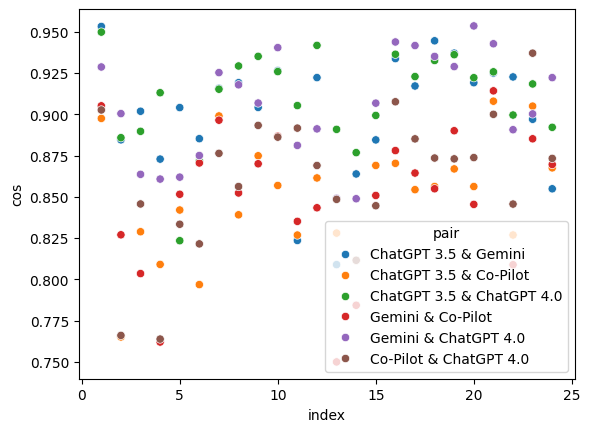

In [53]:
sns.scatterplot(data=cs_dict, x="index", y="cos", hue="pair") # sanity check 

<Axes: xlabel='cos', ylabel='pair'>

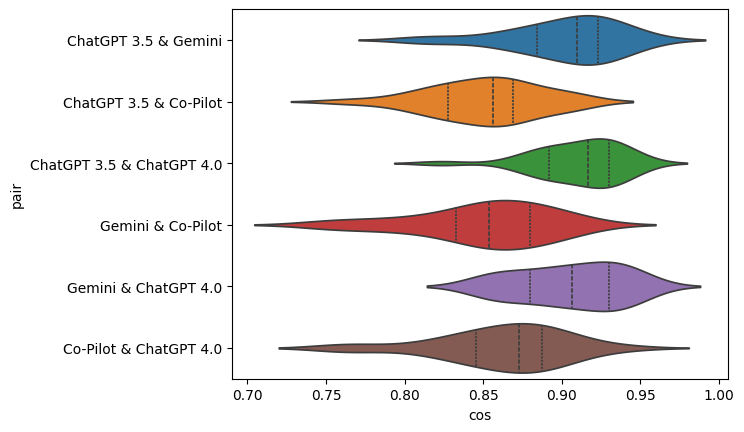

In [54]:
sns.violinplot(data=cs_dict, x="cos", y="pair", hue="pair", inner="quart")

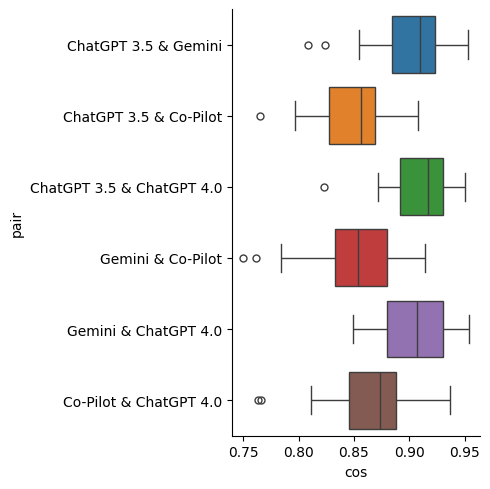

In [55]:
sns.catplot(data=cs_dict, x="cos", y="pair", kind="box", hue="pair")

<Axes: xlabel='cos', ylabel='Count'>

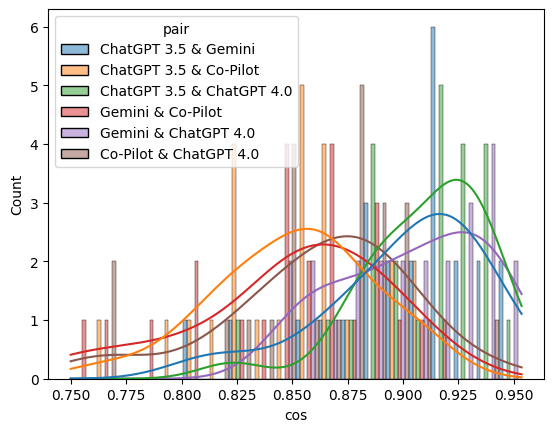

In [56]:
sns.histplot(data=cs_dict, x="cos", bins=20, hue="pair", multiple="dodge", kde=True)

<Axes: xlabel='cos', ylabel='Density'>

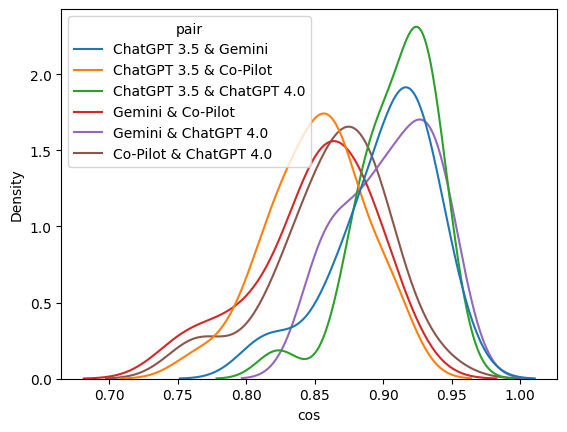

In [57]:
sns.kdeplot(data=cs_dict, x="cos", hue="pair")

<Axes: xlabel='cos', ylabel='Proportion'>

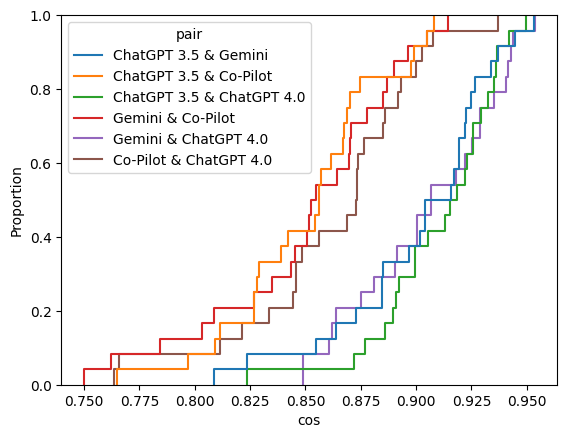

In [58]:
sns.ecdfplot(data=cs_dict, x="cos", hue="pair")

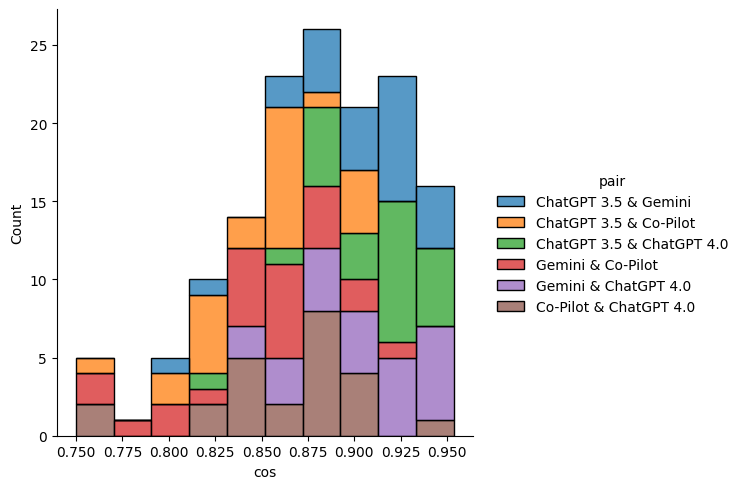

In [59]:
sns.displot(data=cs_dict, x="cos", bins=10, hue="pair", multiple="stack")

#### Take-Aways

When we embed the generated answers with `BioSent2Vec`, the range of similarities is much more limited than with `ClinicalBERT`. That is, for `BioSent2Vec`, we rarely observe instances where the cosine similarity of two answers is below 80%. Again, this is largely due to the **limitation** of `BioSent2Vec`, that heuristic text cleaning is required to remove unnecessary noise, unlike `ClinicalBERT`. We would likely see a notable difference if we introduced dermatological stop words (i.e., words which we expect all of the answers to have, given the context of BCC).

That said, in this setting, ChatGPT 3.5 and ChatGPT 4.0 appear to be the models producing the most similar results (**without statistical significance tests** to back this up).

In [45]:
def stats_sent2vec():
    g3_ge = []
    g3_co = []
    g3_g4 = []
    ge_co = []
    ge_g4 = []
    co_g4 = []
    
    for score, model in zip(cs_dict['cos'], cs_dict['pair']):
        if model == 'ChatGPT 3.5 & Gemini':
            g3_ge.append(score)
        elif model == 'ChatGPT 3.5 & Co-Pilot':
            g3_co.append(score)
        elif model == 'ChatGPT 3.5 & ChatGPT 4.0':
            g3_g4.append(score)
        elif model == 'Gemini & Co-Pilot':
            ge_co.append(score)
        elif model == 'Gemini & ChatGPT 4.0':
            ge_g4.append(score)
        elif model == 'Co-Pilot & ChatGPT 4.0':
            co_g4.append(score)
        else:
            print("ERROR")
        
    assert len(g3_ge) == len(g3_co) == len(g3_g4) == len(ge_co) == len(ge_g4) == len(co_g4)
            
    print(f_oneway(g3_ge, g3_co, g3_g4, ge_co, ge_g4, co_g4))

stats_sent2vec()

F_onewayResult(statistic=13.010202192365268, pvalue=2.2453597168246882e-10)


In [46]:
res = pairwise_tukeyhsd(cs_dict['cos'], cs_dict['pair'])
print(res)
print(f"p-values: {res.pvalues}")

                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
          group1                  group2         meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------
ChatGPT 3.5 & ChatGPT 4.0 ChatGPT 3.5 & Co-Pilot  -0.0505    0.0 -0.0774 -0.0236   True
ChatGPT 3.5 & ChatGPT 4.0   ChatGPT 3.5 & Gemini  -0.0086 0.9398 -0.0355  0.0183  False
ChatGPT 3.5 & ChatGPT 4.0 Co-Pilot & ChatGPT 4.0  -0.0403 0.0004 -0.0672 -0.0134   True
ChatGPT 3.5 & ChatGPT 4.0   Gemini & ChatGPT 4.0   -0.004  0.998 -0.0309  0.0229  False
ChatGPT 3.5 & ChatGPT 4.0      Gemini & Co-Pilot  -0.0495    0.0 -0.0764 -0.0226   True
   ChatGPT 3.5 & Co-Pilot   ChatGPT 3.5 & Gemini   0.0419 0.0002   0.015  0.0688   True
   ChatGPT 3.5 & Co-Pilot Co-Pilot & ChatGPT 4.0   0.0102 0.8806 -0.0167  0.0371  False
   ChatGPT 3.5 & Co-Pilot   Gemini & ChatGPT 4.0   0.0465    0.0  0.0196  0.0734   True
   ChatGPT 3.5 & Co-Pilot      G